In [1]:
%matplotlib inline

In [3]:
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

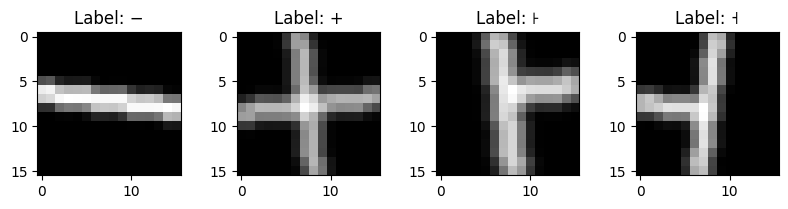

In [5]:
[pm] = qml.data.load('other', name='plus-minus')

X_train = pm.img_train  # shape (1000,16,16)
X_test = pm.img_test  # shape (200,16,16)
Y_train = pm.labels_train  # shape (1000,)
Y_test = pm.labels_test  # shape (200,)

x_vis = [
    (X_train[Y_train == 0])[0],
    (X_train[Y_train == 1])[0],
    (X_train[Y_train == 2])[0],
    (X_train[Y_train == 3])[0],
]
y_vis = [0, 1, 2, 3]


def visualize_data(x, y, pred=None):
    n_img = len(x)
    labels_list = ["\u2212", "\u002b", "\ua714", "\u02e7"]
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(labels_list[y[i]]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
    plt.tight_layout(w_pad=2)
    # plt.show()


visualize_data(x_vis, y_vis)

In [6]:
#### Hyperparameters ####
input_dim = 256
num_classes = 4
num_layers = 32
num_qubits = 8
num_reup = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes 
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cuda


In [7]:
learning_rate = 0.1
epochs = 4
batch_size = 20

feats_train = torch.from_numpy(X_train[:200]).reshape(200, -1).to(device)
feats_test = torch.from_numpy(X_test[:50]).reshape(50, -1).to(device)
labels_train = torch.from_numpy(Y_train[:200]).to(device)
labels_test = torch.from_numpy(Y_test[:50]).to(device)
num_train = feats_train.shape[0]

qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 1.3883214 | Cost (val): 1.3875420 | Approx Acc train: 0.1600000 | Acc val: 0.1200000
Epoch 1/4 | Approx Cost (train): 1.2474109 | Cost (val): 1.2367980 | Approx Acc train: 0.8200000 | Acc val: 0.8800000
Epoch 2/4 | Approx Cost (train): 1.1586360 | Cost (val): 1.1770563 | Approx Acc train: 0.9800000 | Acc val: 0.9600000
Epoch 3/4 | Approx Cost (train): 1.0626023 | Cost (val): 1.0834148 | Approx Acc train: 0.9600000 | Acc val: 0.9800000
Epoch 4/4 | Approx Cost (train): 0.9998829 | Cost (val): 1.0048892 | Approx Acc train: 1.0000000 | Acc val: 0.9800000


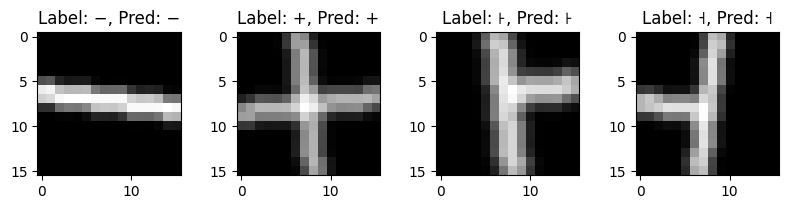

In [8]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(4, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualize_data(x_vis, y_vis, benign_class_output)

In [9]:
def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10):

    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        l = loss(torch.stack(outputs), labels)
        l.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

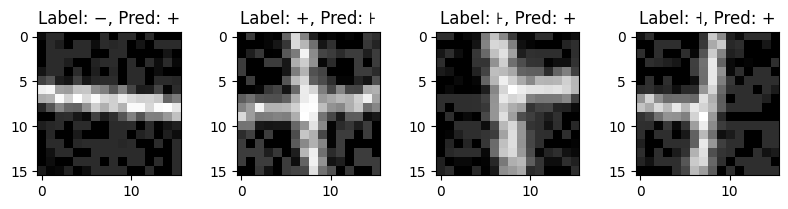

In [10]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations

adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

In [11]:
adv_dataset = (
    PGD(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
            
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

Epoch 0/2 | Approx Cost (train): 0.9998829 | Cost (val): 1.0048892 | Approx Acc train: 1.0000000 | Acc val: 0.9800000
Epoch 1/2 | Approx Cost (train): 0.9359927 | Cost (val): 0.9475186 | Approx Acc train: 0.9600000 | Acc val: 0.9600000
Epoch 2/2 | Approx Cost (train): 0.9082481 | Cost (val): 0.9231466 | Approx Acc train: 0.9800000 | Acc val: 0.9600000


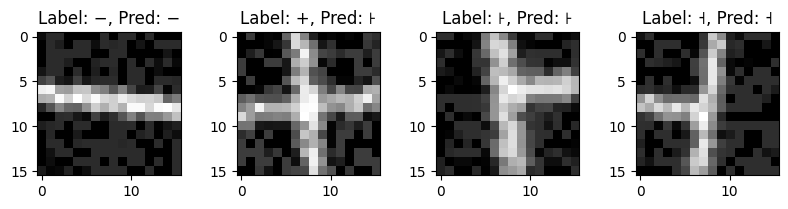

In [12]:
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)